<a href="https://colab.research.google.com/github/LinjingBi/practice-nn-0-to-hero/blob/master/L6_makemore_part5_cnn1(wavenet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In part3's MLP, we concatenate the embedded (32, 3, 10) input into (32, 30), and then pass to linear layer. Basically, we expect the network to find the pattern by analysising 3 words at once. And we seems achieved a fair loss(~2.3). But if we aim to handle more blocks/embedding dims, the parameters from later layers also need to grow, also we can add more layers, etc. But still, handle all blocks as one long 1D tensor might not be a good idea. So here, we introduce another model inspired by [Wavenet](https://arxiv.org/pdf/1609.03499),
this model
for our case, we need to:  
1. raise block_size to 8
2. During the flatten, we try to only concatenate 2 letters at a time, f.e. it was (32, 80), now is (32, 4, 20)...
3. and we continue to do this for the input of every linear hidden layer.

Our network now looks like:

embedding layer -> flatten layer -> linear layer -> batch norm -> tanh -> flatten layer -> linear layer -> batch norm -> tanh -> flatten layer -> linear layer -> batch norm -> tanh -> output layer.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-31 14:05:12--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-07-31 14:05:12 (9.33 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
with open ('names.txt') as f:
  names = f.read().splitlines()

chars = sorted(set("".join(names)))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(vocab_size)


27


In [4]:
import random
random.seed(42)
random.shuffle(names)

In [5]:
block_size = 8
def build_dataset(words):
  X, Y = [], []
  for word in words:
    word = word + '.'
    context = [0] * block_size
    for l in word:
      x = stoi[l]
      X.append(context)
      Y.append(x)
      context = context[1:] + [x]

  return torch.tensor(X), torch.tensor(Y)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x, y in zip(Xtr[:25], Ytr[:25]):
  print("".join(itos[i] for i in x.tolist()) + '---->' + itos[y.item()])

........---->y
.......y---->u
......yu---->h
.....yuh---->e
....yuhe---->n
...yuhen---->g
..yuheng---->.
........---->d
.......d---->i
......di---->o
.....dio---->n
....dion---->d
...diond---->r
..diondr---->e
.diondre---->.
........---->x
.......x---->a
......xa---->v
.....xav---->i
....xavi---->e
...xavie---->n
..xavien---->.
........---->j
.......j---->o
......jo---->r


In [65]:
# --------------------------------------------------Layer
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5  # kaiming init
    self.bias = torch.randn(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight, self.bias] if self.bias is not None else [self.weight]

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # --------------------------
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    # --------------------------
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:   # was 2D from lecture 4
        dim = 0
      elif x.ndim == 3:  # now to support our wavenet model, bn needs to handle 3D input.
        dim = (0,1)  # but we are still interested in the mean and var of all last dim
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat + self.beta
    # update running mean and var for later inference in momentum manner
    with torch.no_grad():
      self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
      self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  def __call__(self, x):
    self.out = self.weight[x]
    return self.out
  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, self.n*C)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ---------------------------------------Model(container for layers)
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [66]:
torch.manual_seed(48)  #  make sure the reproducability of all the random numbers generated by torch

In [67]:
# init model parameters
emb_dim = 24
n_hidden = 128
model = Sequential([
    Embedding(vocab_size, emb_dim),
    FlattenConsecutive(2), Linear(emb_dim*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
  for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 3/5
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

print(sum(p.nelement() for p in parameters))


76579


In [68]:
# start training
import tqdm

max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm.tqdm(range(max_steps)):
  idx = torch.randint(0, Xtr.shape[0], (batch_size,))
  X, Y = Xtr[idx], Ytr[idx]

  logits = model(X)
  loss = F.cross_entropy(logits, Y)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  lossi.append(loss.log10().item())

100%|██████████| 200000/200000 [13:22<00:00, 249.15it/s]


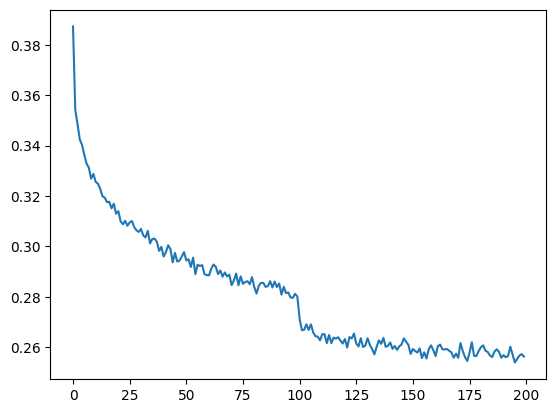

In [69]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim=False))

In [70]:
# turn off training mode in BN layers, so that we can switch to running_mean and running_var
for layer in model.layers:
  if isinstance(layer, BatchNorm1d):
    layer.training = False

In [71]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7878137826919556
val 1.988742470741272


In [ ]:
# loss with gain(3/5) multiplied to weights from linear layers
# train 1.7878137826919556
# val 1.988742470741272

# loss without gain(3/5) multiplied to weights from linear layers
# train 1.7846077680587769
# val 1.9947363138198853

In [39]:
# sample from the model
num = 20
for i in range(num):
  name = ''
  context = [0]*block_size
  while True:
    logits = model(torch.tensor([context]))  # (1,27)
    nxt = torch.multinomial(logits.softmax(dim=1), num_samples=1).item()
    name += itos[nxt]
    if nxt == 0:
      break
    context = context[1:] + [nxt]
  print(name)

calza.
breylo.
naralyn.
emilo.
abelland.
person.
andrine.
joyanna.
fynnter.
hudaisy.
jaskell.
stoney.
moyid.
tiacy.
azadey.
shelby.
abim.
yuvika.
michalli.
lakeelynn.


Few words about the relationship with CNN:  

........ --> d  
.......d --> i  
......di --> o  
.....dio --> n  
....dion --> d  
...diond --> r  
..diondr --> e  
.diondre --> .  

"sliding window"  

"convolution is a "for loop" allows us to forward Linear layers efficiently over space" -- Andrej

